<a href="https://colab.research.google.com/github/MrLishu/PHM-Tongji/blob/main/train_drive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import os
import sys

sys.path.append(os.path.join(os.getcwd(), 'Mrlishu'))
if os.path.exists('/content'):
    os.chdir('/content')
    CODE_DIR = 'PHM-Tongji'
    if not os.path.exists(CODE_DIR):
        !git clone https://github.com/MrLishu/PHM-Tongji.git $CODE_DIR
    os.chdir(f'./{CODE_DIR}')

    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.model_selection import train_test_split

In [4]:
len = {}
for i in (1, 4, 6):
  len[f'c{i}'] = []
  for j in range(315):
    data = pd.read_csv(rf'/content/drive/MyDrive/PHM-Tongji/data/raw/PHM2010/c{i}/c_{i}_{j + 1:03d}.csv')
    len[f'c{i}'].append(data.shape[0])

NameError: ignored

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt


class PHMDataset(Dataset):
    def __init__(self, data_path, dataset_name, train=True, data_num=-1, usecols=('Ax', 'Ay', 'Az'), resample_number=1024, step=1, totalscale=256, wavename='morl'):
        self.data_path = data_path
        self.dataset_name = dataset_name
        self.train = train

        if data_num > 1:
          self.data_num = data_num
        else:
          self.data_num = 315 * len(dataset_name)
        
        self.usecols = usecols
        self.resample_number = resample_number
        self.step = step

        self.signal_length = pd.read_csv(os.path.join(data_path, r'processed/PHM2010/signal_length.csv'))
        self.labelset = {}
        for name in dataset_name:
          self.labelset[name] = pd.read_csv(os.path.join(data_path, rf'raw/PHM2010/{name}_wear.csv'))
        self.columns = ['Fx', 'Fy', 'Fz', 'Ax', 'Ay', 'Az', 'Null']
        sampling_rate = 50000

        fc = pywt.central_frequency(wavename)
        cparam = 2 * fc * totalscale
        self.scales = cparam / np.arange(totalscale, 0, -1)
        self.wavename = wavename
        self.resample_rate = sampling_rate / step
      
    def __len__(self):
        return self.data_num
    
    def __getitem__(self, idx):
        name = self.dataset_name[idx // 315]
        ci = name[1]
        i = idx % 315
        length = self.signal_length[name][i]

        if self.train:
            start = np.random.randint(length - self.resample_number * self.step)
        else:
            start = (length - self.resample_number * self.step) // 2

        signal = pd.read_csv(os.path.join(self.data_path, rf'raw/PHM2010/{name}/c_{ci}_{i + 1:03d}.csv'), names=self.columns, usecols=self.usecols, skiprows=start, nrows=self.step * self.resample_number)
        resampled = signal.to_numpy().T[:, ::self.step]

        resampled -= resampled.mean(axis=-1)[:, np.newaxis]
        resampled /= resampled.std(axis=-1)[:, np.newaxis]

        cwtmatr, frequencies = pywt.cwt(resampled, self.scales, self.wavename, 1 / self.resample_rate)
        cwtmatr = cwtmatr.transpose(1, 0, 2)

        # t = np.arange(resampled.shape[1]) / self.resample_rate
        # plt.figure(figsize=(8, 4))
        # plt.subplot(211)
        # plt.plot(t, resampled[-1])
        # plt.xlabel(u"time(s)")
        # plt.title(u"Time spectrum")
        # plt.subplot(212)
        # plt.contourf(t, frequencies, abs(cwtmatr[-1]))
        # plt.ylabel(u"freq(Hz)")
        # plt.xlabel(u"time(s)")
        # plt.subplots_adjust(hspace=0.4)
        # plt.show()

        label = self.labelset[name].iloc[i, 1:].mean()
        return cwtmatr, label

In [61]:
train_dataset = PHMDataset(r'/content/drive/MyDrive/PHM-Tongji/data', ['c1', 'c4'], False)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)

val_dataset = PHMDataset(r'/content/drive/MyDrive/PHM-Tongji/data', ['c1'], False, 30)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=True, num_workers=2)

63187

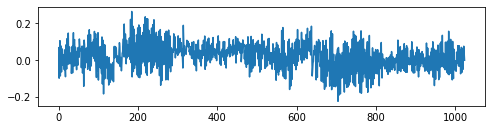

In [62]:
signal = pd.read_csv(os.path.join(r'/content/drive/MyDrive/PHM-Tongji/data', rf'raw/PHM2010/c1/c_1_001.csv')).iloc[:, 5]
signal = signal.to_numpy()
l = signal.shape[0]
signal = signal[l // 2 - 512:l // 2 + 512]
signal.shape
plt.figure(figsize=(8, 4))
plt.subplot(211)
plt.plot(signal)
l // 2 - 512

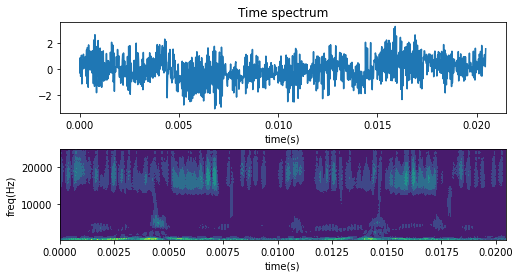

(array([[[-0.12572779,  0.05691982,  0.12309706, ...,  0.17089739,
          -0.18349835,  0.07907247],
         [-0.21393494,  0.16569939,  0.04316161, ...,  0.19156806,
          -0.26334918,  0.1854809 ],
         [-0.28875265,  0.26075606, -0.03563155, ...,  0.20458167,
          -0.32571274,  0.28804035],
         ...,
         [-0.55906158,  0.58892063,  0.8363297 , ...,  0.78041151,
          -1.20755244,  0.25338576],
         [ 0.54924599,  1.48713364,  0.53659959, ..., -0.68290817,
           1.34936944, -1.56792363],
         [ 1.3082976 ,  2.08512354,  0.73917858, ..., -1.10432136,
          -2.66896332, -1.67219262]],
 
        [[-0.12728602,  0.06568382,  0.11766066, ...,  0.18346731,
          -0.19807261,  0.08416101],
         [-0.21258635,  0.17429556,  0.03648673, ...,  0.20863697,
          -0.28570633,  0.2010443 ],
         [-0.28476259,  0.2676885 , -0.04190652, ...,  0.22498308,
          -0.35519549,  0.31334025],
         ...,
         [-0.27809621,  0.8707947

In [56]:
train_dataset[0]

In [ ]:
data, label = next(iter(train_dataloader))
data.shape, label.shape

In [63]:
model = models.resnet18(pretrained=False)
# model.conv1 = nn.Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
model.fc = nn.Linear(in_features=512, out_features=1, bias=True)

device = device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.001)
scheduler = None

num_epochs = 50

In [ ]:
loss_table = []

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    running_loss = 0.0

    # Iterate over data.
    for step, (inputs, labels) in enumerate(train_dataloader):
        model.train()
        inputs = inputs.float().to(device)
        labels = labels.float().to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels[:, np.newaxis])

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    loss_table.append(running_loss)
    print(f'Running loss: {running_loss:.3f}')
    
    val_loss = 0.0
    error_table = []
    for inputs, labels in val_dataloader:
        model.eval()
        inputs = inputs.float().to(device)
        labels = labels.float().to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        val_loss += loss.item()

        error_table += (outputs - labels).flatten().detach().cpu().numpy().tolist()
    
    print(f'Val loss: {val_loss:.3f}')
    print(f'Error mean: {np.abs(error_table).mean():.3f}')
    print(f'Error std: {np.array(error_table).std():.3f}')
    print()


Epoch 0/49
----------
Running loss: 581270.161


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Val loss: 2059.287
Error mean: 13.323
Error std: 11.476

Epoch 1/49
----------


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Running loss: 53643.058
Val loss: 1918.673
Error mean: 12.299
Error std: 11.924

Epoch 2/49
----------
Running loss: 36713.011
Val loss: 1042.294
Error mean: 9.292
Error std: 11.513

Epoch 3/49
----------
Running loss: 18530.816
Val loss: 1293.708
Error mean: 11.212
Error std: 12.397

Epoch 4/49
----------
Running loss: 16427.308
Val loss: 1215.311
Error mean: 10.163
Error std: 11.888

Epoch 5/49
----------
Running loss: 10012.731
Val loss: 2050.353
Error mean: 13.105
Error std: 11.374

Epoch 6/49
----------
Running loss: 10959.402
Val loss: 1666.946
Error mean: 11.725
Error std: 13.194

Epoch 7/49
----------
Running loss: 7088.088
Val loss: 1720.506
Error mean: 11.166
Error std: 12.998

Epoch 8/49
----------
Running loss: 10041.566
Val loss: 1339.247
Error mean: 10.596
Error std: 11.922

Epoch 9/49
----------
Running loss: 8342.149
Val loss: 1550.492
Error mean: 10.191
Error std: 12.693

Epoch 10/49
----------
Running loss: 6316.538
Val loss: 1375.010
Error mean: 9.304
Error std: 12.1

In [22]:
model.eval()

test_epochs = 10

test_dataset = PHMDataset(r'/content/drive/MyDrive/PHM-Tongji/data', ['c6'])
test_dataloader = DataLoader(test_dataset, batch_size=4, num_workers=2)

label_table = []
predict_table = []

for epoch in range(test_epochs):
  print('Epoch {}/{}'.format(epoch, test_epochs - 1))
  print('-' * 10)

  label_table.append([])
  predict_table.append([])

  for inputs, labels in test_dataloader:
    inputs = inputs.float().to(device)
    labels = labels.float().to(device)

    outputs = model(inputs)

    label_table[-1] += labels.flatten().cpu().numpy().tolist()
    predict_table[-1] += outputs.flatten().cpu().detach().numpy().tolist()

labels = np.array(label_table)
predicted = np.array(predict_table)

Epoch 0/9
----------
Epoch 1/9
----------
Epoch 2/9
----------
Epoch 3/9
----------
Epoch 4/9
----------
Epoch 5/9
----------
Epoch 6/9
----------
Epoch 7/9
----------
Epoch 8/9
----------
Epoch 9/9
----------


In [23]:
predicted.shape

(10, 315)

In [28]:
predicted.mean(axis=0)

array([ 70.7268158 , 120.43048782, 123.69195557, 122.329422  ,
       114.03473892, 124.28985748, 124.66302032, 136.39682541,
       127.21336823, 137.35930023, 127.73474197, 117.78426056,
       132.60305328, 131.17757416, 132.07297287, 131.87752533,
       131.68665848, 131.84071808, 134.88467407, 142.42751617,
       127.91921616, 137.17612228, 134.54283829, 140.44174271,
       130.60260468, 138.30974426, 138.89041901, 137.66562347,
       127.73922958, 142.32822113, 136.28320465, 142.02997742,
       136.32817459, 142.09672699, 128.78698959, 143.71660156,
       138.89778824, 135.11018982, 141.46215057, 130.94839478,
       134.54497681, 142.30085907, 143.34087448, 144.77459106,
       139.04930878, 137.96629486, 140.75160446, 144.75423203,
       144.52172928, 145.92323532, 138.93939819, 132.71750259,
       137.68190765, 137.20468445, 140.46499786, 138.259272  ,
       143.83314819, 137.65720444, 142.72806854, 145.83597412,
       133.91816025, 133.96077881, 138.43012619, 137.85

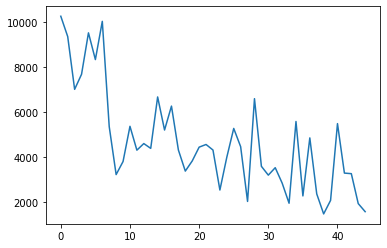

In [31]:
import matplotlib.pyplot as plt

plt.plot(loss_table[5:])

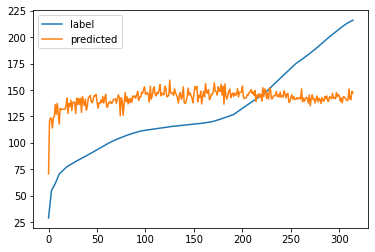

In [39]:
import matplotlib.pyplot as plt

plt.plot(np.arange(len(labels[0])), labels[0], label='label')
plt.plot(np.arange(len(labels[0])), predicted.mean(axis=0), label='predicted')
plt.legend()